In [42]:
import torch
import os
import json
import tqdm
import collections
import random
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import sklearn.decomposition
import sklearn.manifold
import scipy
from InstructorEmbedding import INSTRUCTOR

According to Kohonen, we can do about 50 datapoints per node. For 3.5k that means maybe 60-80 nodes.
I want a 5x4 resolution for display reasons, so maybe 10x8 nodes?

In [3]:
fnames = os.listdir("data")
fields = ['name','smiles','notes']
molecules = []
for fname in tqdm.tqdm(fnames):
    with open(os.path.join("data",fname)) as f:
        mol = json.load(f)
        data = {k:mol[k] for k in fields}
        # Check that the molecule has all the fields of interest
        if all(data.values()):
            molecules.append(data)

# Have to de-dupe the notes for each molecule.
for mol in molecules:
    mol["notes"] = set(mol["notes"])
    
print(f"Found {len(molecules)} molecules.")
molecules[:3]

100%|███████████████████████████████████| 19194/19194 [00:03<00:00, 5641.86it/s]

Found 3440 molecules.


[{'name': 'amyl butyrate',
  'smiles': 'CCCCCOC(=O)CCC',
  'notes': {'banana', 'cherry', 'fruity', 'pineapple', 'sweet', 'tropical'}},
 {'name': 'para-anisyl phenyl acetate',
  'smiles': 'COC1=CC=C(C=C1)COC(=O)CC2=CC=CC=C2',
  'notes': {'anise', 'balsamic', 'honey', 'woody'}},
 {'name': 'dihydrofarnesol',
  'smiles': 'CC(CC/C=C(\\C)/CCC=C(C)C)CCO',
  'notes': {'cyclamen', 'floral', 'metallic'}}]

In [4]:
all_notes = collections.Counter()
for mol in molecules:
    all_notes.update(mol["notes"])
print(f"Found {len(all_notes)} unique notes.")
print("Most common:")
print(all_notes.most_common(5))

Found 502 unique notes.
Most common:
[('fruity', 1060), ('green', 967), ('sweet', 884), ('floral', 706), ('woody', 558)]


In [5]:
all_notes_list = list(all_notes.keys())

def multi_hot(notes):
    indices = torch.tensor([all_notes_list.index(n) for n in notes])
    if len(indices) == 0:
        # Occurs when the notes in the pair were removed due to infrequency.
        raise AttributeError("Found no valid notes.")
    one_hots = torch.nn.functional.one_hot(indices, len(all_notes))
    return one_hots.sum(dim=0).float()

for mol in molecules:
    mol["encoding"] = multi_hot(mol["notes"])

print(molecules[0])
all_encodings = torch.stack([mol["encoding"] for mol in molecules])

{'name': 'amyl butyrate', 'smiles': 'CCCCCOC(=O)CCC', 'notes': {'pineapple', 'tropical', 'fruity', 'cherry', 'banana', 'sweet'}, 'encoding': tensor([1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [40]:
all_encodeds = []
for p in tqdm.tqdm([5,50,100]):
    X_embedded = sklearn.manifold.TSNE(n_components=2, learning_rate='auto',init='random', perplexity=p).fit_transform(all_encodings)
    all_encodeds.append(X_embedded)

100%|█████████████████████████████████████████████| 3/3 [00:30<00:00, 10.25s/it]


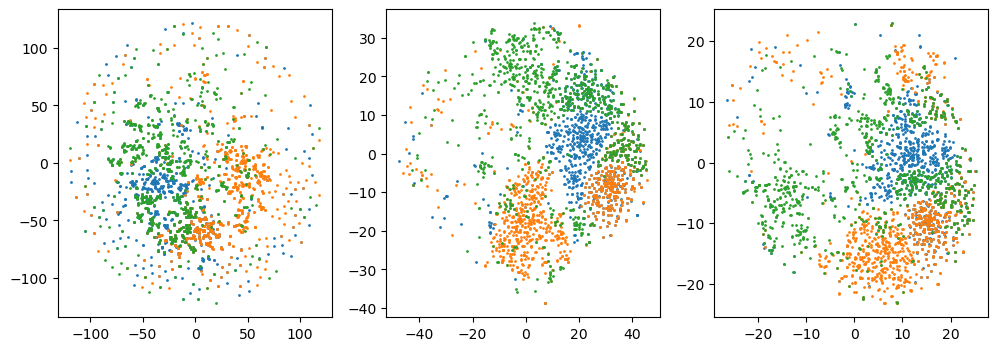

In [41]:
fig, axs = plt.subplots(1,3,figsize=(12,4))
for ax_i, X_embedded in enumerate(all_encodeds):
    for note in ["fruity","green","sweet"]:
        pcas = []
        for i, mol in enumerate(molecules):
            if note in mol["notes"]:
                eps = 5e-2
                pcas.append(X_embedded[i]+np.random.uniform(low=-eps, high=eps, size=2))
        pcas = np.stack(pcas)
        axs[ax_i].scatter(pcas[:,0],pcas[:,1],s=1)
plt.show()

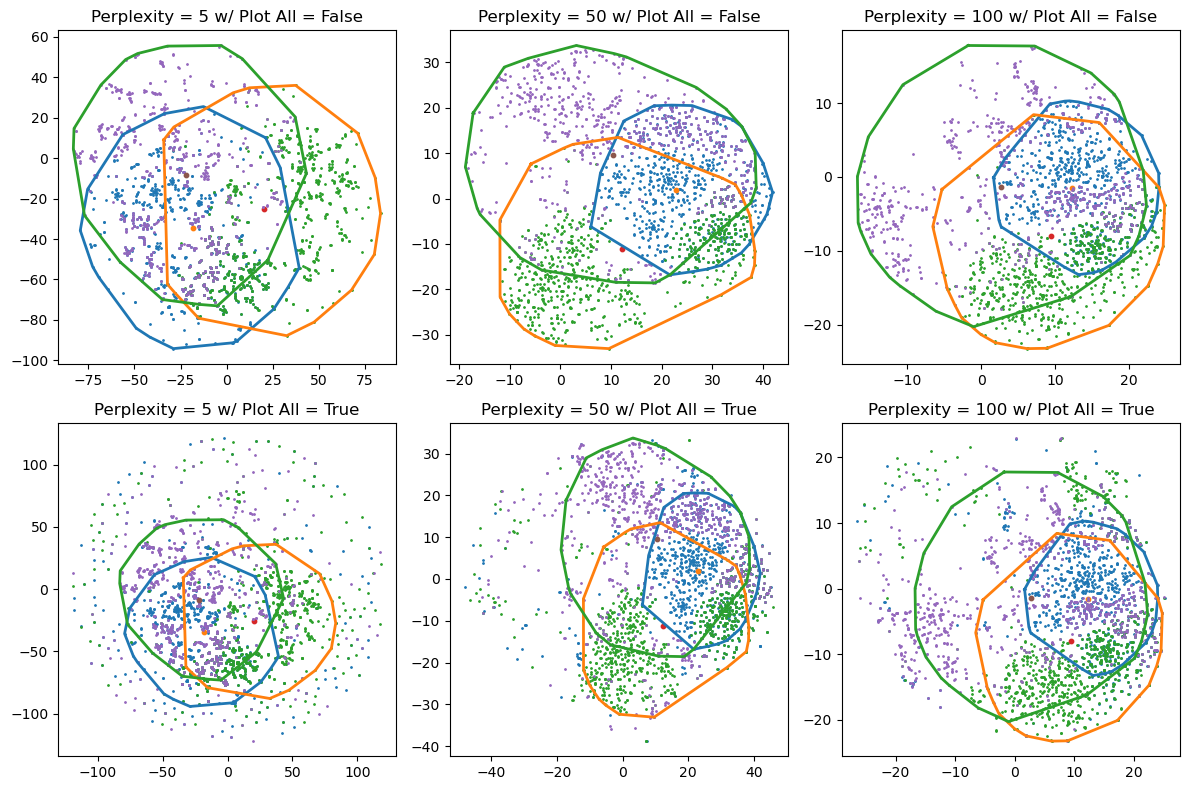

In [121]:
fig, axs = plt.subplots(2,3,figsize=(12,8))
for ax_i, X_embedded in enumerate(all_encodeds):
    for note in ["fruity","green","sweet"]:
        pcas = []
        for i, mol in enumerate(molecules):
            if note in mol["notes"]:
                eps = 5e-2
                pcas.append(X_embedded[i]+np.random.uniform(low=-eps, high=eps, size=2))
        mean = np.mean(pcas,axis=0)
        pcas = np.stack(pcas)
        dists = np.linalg.norm(pcas-mean,axis=1)
        q = np.quantile(dists,.8)
        mask = dists < q
        pcas2 = []
        for i, pca in enumerate(pcas):
            if mask[i]:
                pcas2.append(pca)
        pcas2 = np.stack(pcas2)
        hull = scipy.spatial.ConvexHull(pcas2)
        # Close the loop by adding the last vertex over again.
        vertices = np.append(hull.vertices,hull.vertices[0])
        for pi, plot_all in enumerate([False,True]):
            axs[pi][ax_i].plot(pcas2[vertices,0], pcas2[vertices,1], '-', lw=2)
            # Plot all points
            if plot_all:
                axs[pi][ax_i].scatter(pcas[:,0],pcas[:,1],s=1)
            else:
                axs[pi][ax_i].scatter(pcas2[:,0],pcas2[:,1],s=1)
            axs[pi][ax_i].scatter(mean[0],mean[1],s=10)
            axs[pi][ax_i].set_title(f"Perplexity = {[5,50,100][ax_i]} w/ Plot All = {plot_all}")
plt.tight_layout()
plt.show()

In [125]:
model = INSTRUCTOR('hkunlp/instructor-large')
instruction = "Represent the olfactory notes so that embeddings vary for dissimilar molecules:"

load INSTRUCTOR_Transformer
max_seq_length  512


In [126]:
note_sentences = [[instruction,", ".join(mol["notes"])] for mol in molecules]
note_embeds = model.encode(note_sentences)

In [127]:
all_embeddeds = []
for p in tqdm.tqdm([5,50,100]):
    X_embedded = sklearn.manifold.TSNE(n_components=2, learning_rate='auto',init='random', perplexity=p).fit_transform(note_embeds)
    all_embeddeds.append(X_embedded)

100%|█████████████████████████████████████████████| 3/3 [00:28<00:00,  9.49s/it]


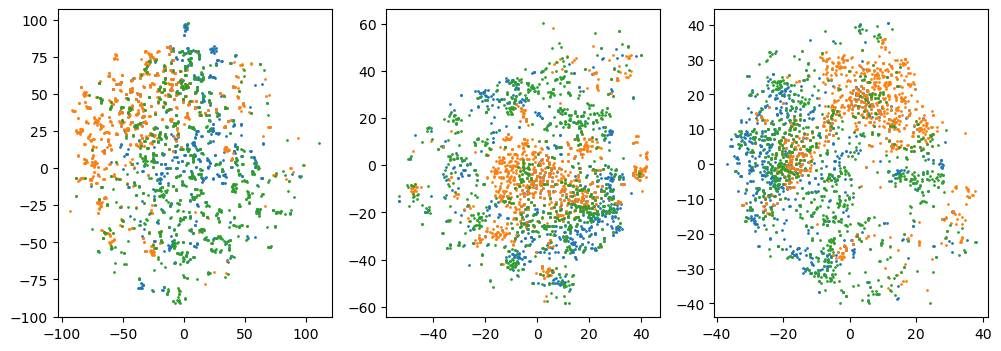

In [128]:
fig, axs = plt.subplots(1,3,figsize=(12,4))
for ax_i, X_embedded in enumerate(all_embeddeds):
    for note in ["fruity","green","sweet"]:
        pcas = []
        for i, mol in enumerate(molecules):
            if note in mol["notes"]:
                eps = 5e-2
                pcas.append(X_embedded[i]+np.random.uniform(low=-eps, high=eps, size=2))
        pcas = np.stack(pcas)
        axs[ax_i].scatter(pcas[:,0],pcas[:,1],s=1)
plt.show()

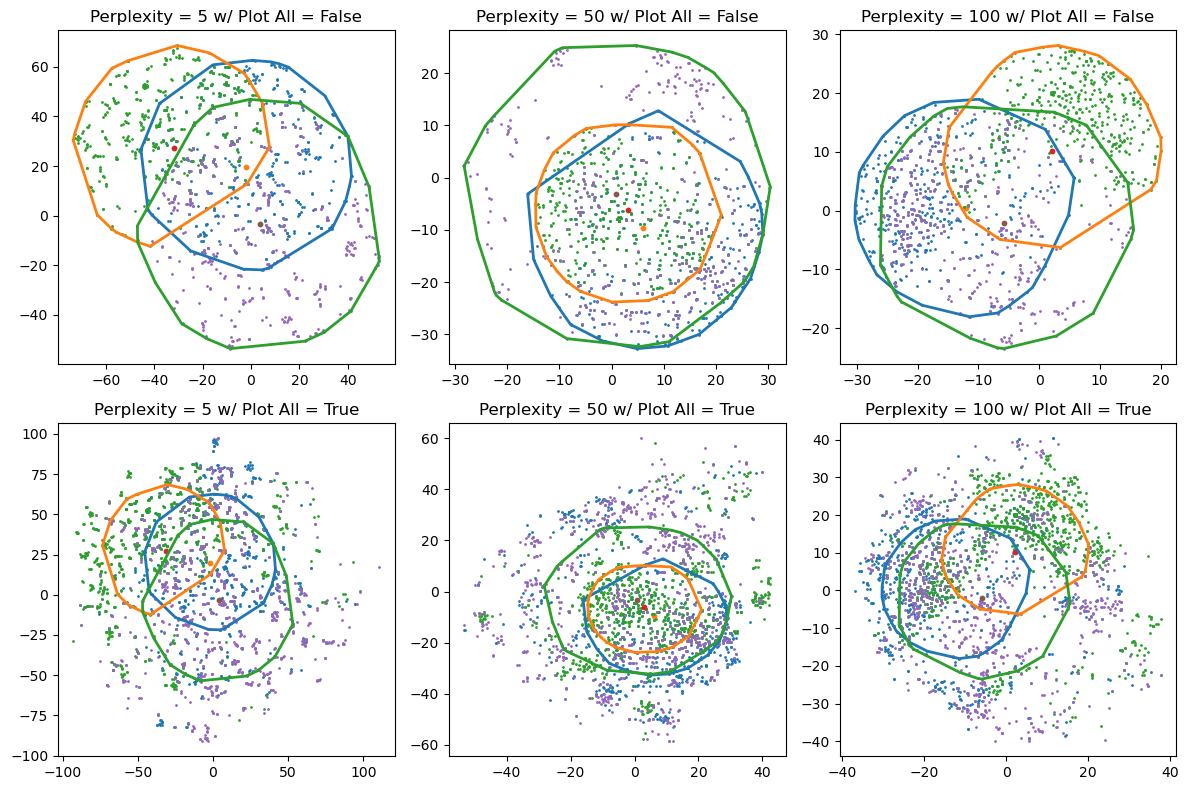

In [135]:
fig, axs = plt.subplots(2,3,figsize=(12,8))
for ax_i, X_embedded in enumerate(all_embeddeds):
    for note in ["fruity","green","sweet"]:
        pcas = []
        for i, mol in enumerate(molecules):
            if note in mol["notes"]:
                eps = 5e-2
                pcas.append(X_embedded[i]+np.random.uniform(low=-eps, high=eps, size=2))
        mean = np.mean(pcas,axis=0)
        pcas = np.stack(pcas)
        dists = np.linalg.norm(pcas-mean,axis=1)
        q = np.quantile(dists,.5)
        mask = dists < q
        pcas2 = []
        for i, pca in enumerate(pcas):
            if mask[i]:
                pcas2.append(pca)
        pcas2 = np.stack(pcas2)
        hull = scipy.spatial.ConvexHull(pcas2)
        # Close the loop by adding the last vertex over again.
        vertices = np.append(hull.vertices,hull.vertices[0])
        for pi, plot_all in enumerate([False,True]):
            axs[pi][ax_i].plot(pcas2[vertices,0], pcas2[vertices,1], '-', lw=2)
            # Plot all points
            if plot_all:
                axs[pi][ax_i].scatter(pcas[:,0],pcas[:,1],s=1)
            else:
                axs[pi][ax_i].scatter(pcas2[:,0],pcas2[:,1],s=1)
            axs[pi][ax_i].scatter(mean[0],mean[1],s=10)
            axs[pi][ax_i].set_title(f"Perplexity = {[5,50,100][ax_i]} w/ Plot All = {plot_all}")
plt.tight_layout()
plt.show()